In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Reshape, LSTM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import cvxpy as cp

print("All libraries are successfully installed.")


All libraries are successfully installed.


In [ ]:
Step 1: Load and Preprocess Data

In [4]:
import os
import pandas as pd

# Updated file path
file_path = r'C:\Users\user\Desktop\MyProject\Traffic flow optimization\DataSet\traffic.csv'

# Check if the file exists at the specified path
if os.path.exists(file_path):
    print("File found at the specified path.")
else:
    print("File not found. Please check the file path and name.")

# Attempt to load the data
try:
    data = pd.read_csv(file_path)
    print("File loaded successfully")
    print(data.head())  # Display the first few rows of the dataframe to confirm
except FileNotFoundError as e:
    print(f"File not found: {e}")
except PermissionError as e:
    print(f"Permission denied: {e}")
except Exception as e:
    print(f"An error occurred: {e}")


File found at the specified path.
File loaded successfully
              DateTime  Junction  Vehicles           ID
0  2015-11-01 00:00:00         1        15  20151101001
1  2015-11-01 01:00:00         1        13  20151101011
2  2015-11-01 02:00:00         1        10  20151101021
3  2015-11-01 03:00:00         1         7  20151101031
4  2015-11-01 04:00:00         1         9  20151101041


In [ ]:
Data Preprocessing

In [5]:
# Convert 'DateTime' to datetime object
data['DateTime'] = pd.to_datetime(data['DateTime'])

# Extract useful features from the datetime
data['Year'] = data['DateTime'].dt.year
data['Month'] = data['DateTime'].dt.month
data['Day'] = data['DateTime'].dt.day
data['Hour'] = data['DateTime'].dt.hour

# Drop the original DateTime column and ID column
data = data.drop(['DateTime', 'ID'], axis=1)

# Normalize the data
scaler = StandardScaler()
data[['Junction', 'Vehicles', 'Year', 'Month', 'Day', 'Hour']] = scaler.fit_transform(data[['Junction', 'Vehicles', 'Year', 'Month', 'Day', 'Hour']])

# Prepare data for training and testing
X = data.drop('Vehicles', axis=1)
y = data['Vehicles']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to numpy arrays
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

print("Data preprocessing completed.")


Data preprocessing completed.


In [ ]:
Prepare Data for CNN and LSTM

In [6]:
# Function to create sequences
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Create sequences for training and testing
time_steps = 10  # Number of time steps for LSTM
X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_steps)

print("Sequence creation completed.")


Sequence creation completed.


In [7]:
import pandas as pd

# Load the dataset from a CSV file
data = pd.read_csv(r'C:\Users\user\Desktop\MyProject\Traffic flow optimization\DataSet\traffic.csv')

# Print the column names to verify
print(data.columns)


Index(['DateTime', 'Junction', 'Vehicles', 'ID'], dtype='object')


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset from a CSV file
data = pd.read_csv(r'C:\Users\user\Desktop\MyProject\Traffic flow optimization\DataSet\traffic.csv')

# Define the correct target column name
target_column = 'Vehicles'  # Use the correct case

# Split into features and target
X = data.drop(columns=[target_column])  # Features: drop the target column
y = data[target_column]                 # Target variable: vehicle count

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the split datasets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(38496, 3) (9624, 3) (38496,) (9624,)


In [9]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['Junction']),  # Encode the Junction column
        ('num', StandardScaler(), ['ID'])       # Scale the ID column
    ],
    remainder='passthrough'                     # Keep the DateTime column as is
)

# Apply preprocessing to the training and testing data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Check the shape of the preprocessed data
print(X_train_preprocessed.shape, X_test_preprocessed.shape)


(38496, 6) (9624, 6)


In [ ]:
Build and Train CNN Model

In [10]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten
import numpy as np
import pandas as pd

# Load the dataset from a CSV file
data = pd.read_csv(r'C:\Users\user\Desktop\MyProject\Traffic flow optimization\DataSet\traffic.csv')

# Convert DateTime column to datetime type
data['DateTime'] = pd.to_datetime(data['DateTime'])

# Extract useful features from the DateTime column
data['Hour'] = data['DateTime'].dt.hour
data['DayOfWeek'] = data['DateTime'].dt.dayofweek

# Drop the original DateTime column
data = data.drop(columns=['DateTime'])

# Split into features and target
X = data.drop(columns=['Vehicles'])
y = data['Vehicles']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['Junction', 'DayOfWeek']),  # Encode categorical columns
        ('num', StandardScaler(), ['ID', 'Hour'])            # Scale numerical columns
    ]
)

# Apply preprocessing to the training and testing data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Convert the data to a compatible type
X_train_preprocessed = X_train_preprocessed.astype(np.float32)
X_test_preprocessed = X_test_preprocessed.astype(np.float32)

# Check the shape of the preprocessed data
print(X_train_preprocessed.shape, X_test_preprocessed.shape)

# Reshape the data to fit the Conv1D layer
X_train_cnn = X_train_preprocessed.reshape((X_train_preprocessed.shape[0], X_train_preprocessed.shape[1], 1))
X_test_cnn = X_test_preprocessed.reshape((X_test_preprocessed.shape[0], X_test_preprocessed.shape[1], 1))

# Define the CNN model
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)  # Single output for regression
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the CNN model
cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_split=0.2)


(38496, 13) (9624, 13)
Epoch 1/10
963/963 [==============================] - 9s 4ms/step - loss: 162.4587 - mae: 8.0788 - val_loss: 82.5279 - val_mae: 6.0582
Epoch 2/10
963/963 [==============================] - 4s 4ms/step - loss: 78.2697 - mae: 5.8308 - val_loss: 75.0321 - val_mae: 5.6062
Epoch 3/10
963/963 [==============================] - 4s 4ms/step - loss: 71.4796 - mae: 5.5653 - val_loss: 67.2398 - val_mae: 5.3352
Epoch 4/10
963/963 [==============================] - 4s 4ms/step - loss: 64.5296 - mae: 5.2452 - val_loss: 61.3946 - val_mae: 5.0208
Epoch 5/10
963/963 [==============================] - 4s 4ms/step - loss: 58.6103 - mae: 4.9202 - val_loss: 54.3421 - val_mae: 4.7038
Epoch 6/10
963/963 [==============================] - 4s 5ms/step - loss: 53.0466 - mae: 4.6282 - val_loss: 49.7296 - val_mae: 4.4439
Epoch 7/10
963/963 [==============================] - 4s 4ms/step - loss: 49.1589 - mae: 4.4205 - val_loss: 45.7696 - val_mae: 4.3078
Epoch 8/10
963/963 [==================

In [11]:
# Evaluate the model on the test data
test_loss, test_mae = cnn_model.evaluate(X_test_cnn, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")


301/301 [==============================] - 1s 2ms/step - loss: 40.2189 - mae: 3.9748
Test Loss: 40.21887969970703
Test MAE: 3.9747908115386963


In [12]:
# Make predictions using the test data
cnn_predictions = cnn_model.predict(X_test_cnn)

# Convert predictions to a 1D array
cnn_predictions = cnn_predictions.flatten()

# Display the first few predictions and actual values
print("Predictions:", cnn_predictions[:5])
print("Actual:", y_test[:5].values)


301/301 [==============================] - 1s 2ms/step
Predictions: [10.387232 16.772764  8.621245 10.927724 25.515558]
Actual: [ 9 97 13 11 24]


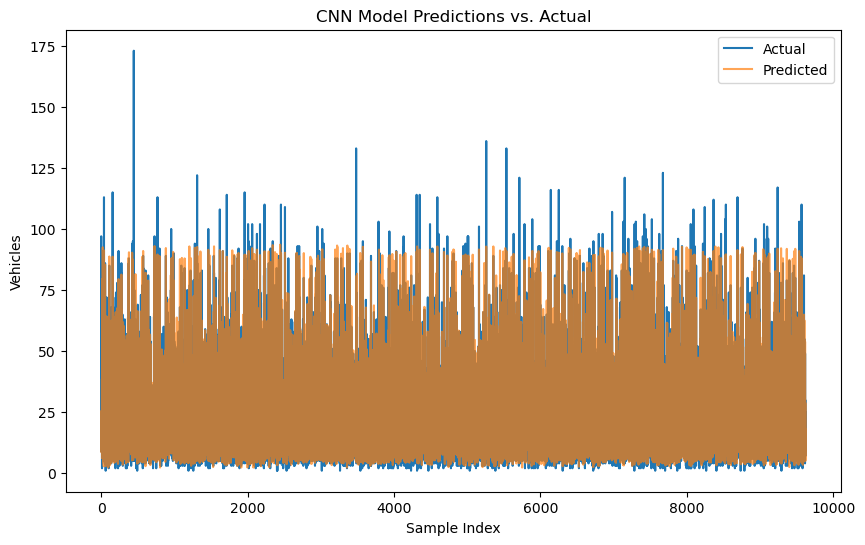

In [13]:
import matplotlib.pyplot as plt

# Plot predictions vs. actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(cnn_predictions, label='Predicted', alpha=0.7)
plt.title('CNN Model Predictions vs. Actual')
plt.xlabel('Sample Index')
plt.ylabel('Vehicles')
plt.legend()
plt.show()


In [ ]:
#Train the CNN Model for Vehicle Tracking

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Convert X_train and X_test to NumPy arrays if they are DataFrames
X_train = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
X_test = X_test.values if isinstance(X_test, pd.DataFrame) else X_test

# Reshape X_train and X_test if they are 2D
if len(X_train.shape) == 2:
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define and compile the CNN model
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
cnn_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Save the model
cnn_model.save('vehicle_tracking_model.h5')


Epoch 1/10
1203/1203 [==============================] - 6s 3ms/step - loss: -1198590215061504.0000 - accuracy: 0.0031 - val_loss: -4541989118803968.0000 - val_accuracy: 0.0027
Epoch 2/10
1203/1203 [==============================] - 5s 4ms/step - loss: -15217231264743424.0000 - accuracy: 0.0032 - val_loss: -29737206801235968.0000 - val_accuracy: 0.0027
Epoch 3/10
1203/1203 [==============================] - 4s 3ms/step - loss: -55789370317209600.0000 - accuracy: 0.0032 - val_loss: -84960629277851648.0000 - val_accuracy: 0.0027
Epoch 4/10
1203/1203 [==============================] - 4s 3ms/step - loss: -129052815078195200.0000 - accuracy: 0.0032 - val_loss: -173831963717664768.0000 - val_accuracy: 0.0027
Epoch 5/10
1203/1203 [==============================] - 4s 3ms/step - loss: -238959490584543232.0000 - accuracy: 0.0032 - val_loss: -300765152305741824.0000 - val_accuracy: 0.0027
Epoch 6/10
1203/1203 [==============================] - 4s 3ms/step - loss: -389819959158505472.0000 - accur

C:\Users\user\.conda\envs\traffic_flow_opt_clean\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#Build and Train LSTM Model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
lstm_model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train_preprocessed.shape[1], 1)),
    Dense(64, activation='relu'),
    Dense(1)  # Single output for regression
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Reshape the data to fit the LSTM input requirements
X_train_lstm = X_train_preprocessed.reshape((X_train_preprocessed.shape[0], X_train_preprocessed.shape[1], 1))
X_test_lstm = X_test_preprocessed.reshape((X_test_preprocessed.shape[0], X_test_preprocessed.shape[1], 1))

# Train the LSTM model
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the LSTM model
test_loss, test_mae = lstm_model.evaluate(X_test_lstm, y_test)
print(f"LSTM Test Loss: {test_loss}")
print(f"LSTM Test MAE: {test_mae}")

# Make predictions
lstm_predictions = lstm_model.predict(X_test_lstm)
print("Predictions:", lstm_predictions[:5].flatten())
print("Actual:", y_test[:5].to_numpy())


Epoch 1/10
963/963 [==============================] - 15s 12ms/step - loss: 206.7036 - mae: 9.7252 - val_loss: 106.3274 - val_mae: 7.0282
Epoch 2/10
963/963 [==============================] - 11s 12ms/step - loss: 112.0002 - mae: 7.0560 - val_loss: 104.6445 - val_mae: 6.7126
Epoch 3/10
963/963 [==============================] - 12s 12ms/step - loss: 105.0291 - mae: 6.8047 - val_loss: 98.9303 - val_mae: 6.8323
Epoch 4/10
963/963 [==============================] - 11s 12ms/step - loss: 101.0379 - mae: 6.6476 - val_loss: 105.3066 - val_mae: 6.4705
Epoch 5/10
963/963 [==============================] - 11s 12ms/step - loss: 90.7657 - mae: 6.3100 - val_loss: 80.2523 - val_mae: 5.9508
Epoch 6/10
963/963 [==============================] - 11s 12ms/step - loss: 81.0344 - mae: 5.9680 - val_loss: 73.0298 - val_mae: 5.6498
Epoch 7/10
963/963 [==============================] - 11s 12ms/step - loss: 66.8492 - mae: 5.3517 - val_loss: 59.8450 - val_mae: 5.0527
Epoch 8/10
963/963 [=====================

301/301 [==============================] - 2s 6ms/step - loss: 51.5654 - mae: 4.4110
LSTM Test Loss: 51.565425872802734
LSTM Test MAE: 4.411009311676025
301/301 [==============================] - 2s 5ms/step
LSTM Predictions: [10.206949  11.492714   7.8123507  9.051409  23.9898   ]
Actual: [ 9 97 13 11 24]


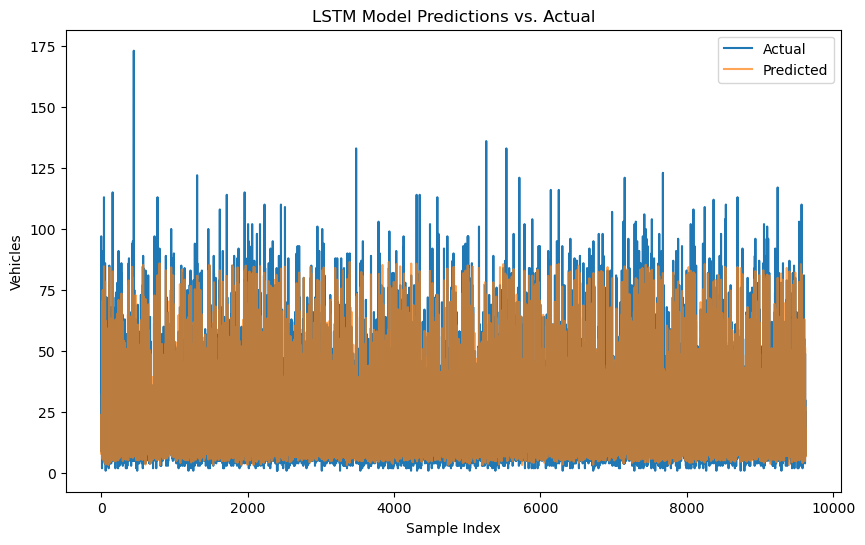

In [19]:
# Evaluate the LSTM model on the test data
test_loss_lstm, test_mae_lstm = lstm_model.evaluate(X_test_lstm, y_test)

print(f"LSTM Test Loss: {test_loss_lstm}")
print(f"LSTM Test MAE: {test_mae_lstm}")

# Make predictions using the LSTM model
lstm_predictions = lstm_model.predict(X_test_lstm)

# Convert predictions to a 1D array
lstm_predictions = lstm_predictions.flatten()

# Display the first few predictions and actual values
print("LSTM Predictions:", lstm_predictions[:5])
print("Actual:", y_test[:5].values)

# Plot predictions vs. actual values for LSTM
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(lstm_predictions, label='Predicted', alpha=0.7)
plt.title('LSTM Model Predictions vs. Actual')
plt.xlabel('Sample Index')
plt.ylabel('Vehicles')
plt.legend()
plt.show()


In [ ]:
#Traffic Light Control Model

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Convert X_train and X_test to NumPy arrays if they are DataFrames
X_train = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
X_test = X_test.values if isinstance(X_test, pd.DataFrame) else X_test

# Reshape X_train and X_test if they are 2D
if len(X_train.shape) == 2:
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define and compile the CNN model for Traffic Light Control
traffic_light_control_model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1, activation='sigmoid')
])

traffic_light_control_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
traffic_light_control_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Save the model
traffic_light_control_model.save('traffic_light_control_model.h5')


Epoch 1/10
1203/1203 [==============================] - 5s 3ms/step - loss: -660675089137664.0000 - accuracy: 0.0032 - val_loss: -2553158609928192.0000 - val_accuracy: 0.0027
Epoch 2/10
1203/1203 [==============================] - 4s 3ms/step - loss: -8737522016321536.0000 - accuracy: 0.0032 - val_loss: -17069729042661376.0000 - val_accuracy: 0.0027
Epoch 3/10
1203/1203 [==============================] - 4s 3ms/step - loss: -31934834192416768.0000 - accuracy: 0.0032 - val_loss: -48672583737933824.0000 - val_accuracy: 0.0027
Epoch 4/10
1203/1203 [==============================] - 4s 3ms/step - loss: -74153821546217472.0000 - accuracy: 0.0032 - val_loss: -99928504405065728.0000 - val_accuracy: 0.0027
Epoch 5/10
1203/1203 [==============================] - 4s 3ms/step - loss: -137181057865744384.0000 - accuracy: 0.0032 - val_loss: -172516587033591808.0000 - val_accuracy: 0.0027
Epoch 6/10
1203/1203 [==============================] - 4s 3ms/step - loss: -223298768513007616.0000 - accuracy:

In [ ]:
Hybrid Model (CNN + LSTM) Evaluation

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Flatten

# Define the Hybrid CNN-LSTM model
hybrid_model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_preprocessed.shape[1], 1)),
    LSTM(50, activation='relu', return_sequences=True),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)  # Single output for regression
])

# Compile the model
hybrid_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Reshape the data to fit the Hybrid model
X_train_hybrid = X_train_preprocessed.reshape((X_train_preprocessed.shape[0], X_train_preprocessed.shape[1], 1))
X_test_hybrid = X_test_preprocessed.reshape((X_test_preprocessed.shape[0], X_test_preprocessed.shape[1], 1))

# Train the Hybrid model
hybrid_model.fit(X_train_hybrid, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Make predictions using the Hybrid model
hybrid_predictions = hybrid_model.predict(X_test_hybrid)

# Convert predictions to binary classes for metric calculations
threshold = 10  # Adjust based on your specific requirements
hybrid_class_predictions = (hybrid_predictions >= threshold).astype(int)

# Now you can calculate accuracy, precision, recall, and F1 score for the Hybrid model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert actual values to binary classes
y_test_class = (y_test.to_numpy() >= threshold).astype(int)

# Calculate metrics for Hybrid model
hybrid_accuracy = accuracy_score(y_test_class, hybrid_class_predictions)
hybrid_precision = precision_score(y_test_class, hybrid_class_predictions, zero_division=0)
hybrid_recall = recall_score(y_test_class, hybrid_class_predictions, zero_division=0)
hybrid_f1 = f1_score(y_test_class, hybrid_class_predictions, zero_division=0)

# Print metrics
print("\nHybrid Model Metrics:")
print(f"Accuracy: {hybrid_accuracy:.4f}, Precision: {hybrid_precision:.4f}, Recall: {hybrid_recall:.4f}, F1 Score: {hybrid_f1:.4f}")


Epoch 1/10
963/963 [==============================] - 15s 13ms/step - loss: 169.9882 - mae: 8.4428 - val_loss: 100.8078 - val_mae: 6.2770
Epoch 2/10
963/963 [==============================] - 11s 12ms/step - loss: 73.5125 - mae: 5.5946 - val_loss: 56.2118 - val_mae: 5.1182
Epoch 3/10
963/963 [==============================] - 12s 12ms/step - loss: 52.9849 - mae: 4.6206 - val_loss: 46.0361 - val_mae: 4.3026
Epoch 4/10
963/963 [==============================] - 11s 12ms/step - loss: 49.3037 - mae: 4.4202 - val_loss: 50.2073 - val_mae: 4.4070
Epoch 5/10
963/963 [==============================] - 11s 12ms/step - loss: 48.2537 - mae: 4.3538 - val_loss: 42.8788 - val_mae: 4.1085
Epoch 6/10
963/963 [==============================] - 11s 12ms/step - loss: 47.3450 - mae: 4.2990 - val_loss: 44.2033 - val_mae: 4.1848
Epoch 7/10
963/963 [==============================] - 11s 12ms/step - loss: 46.2448 - mae: 4.2264 - val_loss: 43.0270 - val_mae: 4.1780
Epoch 8/10
963/963 [==========================

In [ ]:
#Congestion Detection Model

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Convert X_train and X_test to NumPy arrays if they are DataFrames
X_train = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
X_test = X_test.values if isinstance(X_test, pd.DataFrame) else X_test

# Reshape X_train and X_test if they are 2D
if len(X_train.shape) == 2:
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define and compile the CNN model for Congestion Detection
congestion_detection_model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1, activation='sigmoid')
])

congestion_detection_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
congestion_detection_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Save the model
congestion_detection_model.save('congestion_detection_model.h5')


Epoch 1/10
1203/1203 [==============================] - 5s 3ms/step - loss: -765277474127872.0000 - accuracy: 0.0032 - val_loss: -2897186027208704.0000 - val_accuracy: 0.0027
Epoch 2/10
1203/1203 [==============================] - 4s 3ms/step - loss: -9578321457184768.0000 - accuracy: 0.0032 - val_loss: -18575928976211968.0000 - val_accuracy: 0.0027
Epoch 3/10
1203/1203 [==============================] - 4s 3ms/step - loss: -34518117434523648.0000 - accuracy: 0.0032 - val_loss: -52206981045288960.0000 - val_accuracy: 0.0027
Epoch 4/10
1203/1203 [==============================] - 4s 3ms/step - loss: -79216651685330944.0000 - accuracy: 0.0032 - val_loss: -106570825947152384.0000 - val_accuracy: 0.0027
Epoch 5/10
1203/1203 [==============================] - 4s 3ms/step - loss: -146172254072340480.0000 - accuracy: 0.0032 - val_loss: -183693208629280768.0000 - val_accuracy: 0.0027
Epoch 6/10
1203/1203 [==============================] - 4s 3ms/step - loss: -237897156193681408.0000 - accuracy

C:\Users\user\.conda\envs\traffic_flow_opt_clean\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
# Evaluate the hybrid CNN-LSTM model on the test data
test_loss_hybrid, test_mae_hybrid = model.evaluate(X_test_cnn_lstm, y_test)

print(f"Hybrid CNN-LSTM Test Loss: {test_loss_hybrid}")
print(f"Hybrid CNN-LSTM Test MAE: {test_mae_hybrid}")

# Make predictions using the hybrid CNN-LSTM model
hybrid_predictions = model.predict(X_test_cnn_lstm)

# Convert predictions to a 1D array
hybrid_predictions = hybrid_predictions.flatten()

# Display the first few predictions and actual values
print("Hybrid CNN-LSTM Predictions:", hybrid_predictions[:5])
print("Actual:", y_test[:5].values)

# Plot predictions vs. actual values for Hybrid CNN-LSTM
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(hybrid_predictions, label='Predicted', alpha=0.7)
plt.title('Hybrid CNN-LSTM Model Predictions vs. Actual')
plt.xlabel('Sample Index')
plt.ylabel('Vehicles')
plt.legend()
plt.show()


NameError: name 'model' is not defined

In [ ]:
#Performance Matrics

In [2]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assume cnn_model, lstm_model, and hybrid_model have been trained and exist in the session
# Obtain predictions from each model
cnn_predictions = cnn_model.predict(X_test_cnn)
lstm_predictions = lstm_model.predict(X_test_lstm)
hybrid_predictions = hybrid_model.predict(X_test_hybrid)

# Define a threshold to classify predictions
threshold = 10  # Adjust this threshold based on your specific data and requirements

# Function to convert regression outputs to binary classes
def to_class(predictions, threshold):
    return (predictions >= threshold).astype(int)

# Convert the predictions to binary classes
cnn_class_predictions = to_class(cnn_predictions, threshold)
lstm_class_predictions = to_class(lstm_predictions, threshold)
hybrid_class_predictions = to_class(hybrid_predictions, threshold)

# Convert the actual values to binary classes
y_test_class = to_class(y_test.to_numpy(), threshold)

# Calculate metrics for CNN
cnn_accuracy = accuracy_score(y_test_class, cnn_class_predictions)
cnn_precision = precision_score(y_test_class, cnn_class_predictions, zero_division=0)
cnn_recall = recall_score(y_test_class, cnn_class_predictions, zero_division=0)
cnn_f1 = f1_score(y_test_class, cnn_class_predictions, zero_division=0)

# Calculate metrics for LSTM
lstm_accuracy = accuracy_score(y_test_class, lstm_class_predictions)
lstm_precision = precision_score(y_test_class, lstm_class_predictions, zero_division=0)
lstm_recall = recall_score(y_test_class, lstm_class_predictions, zero_division=0)
lstm_f1 = f1_score(y_test_class, lstm_class_predictions, zero_division=0)

# Calculate metrics for Hybrid model
hybrid_accuracy = accuracy_score(y_test_class, hybrid_class_predictions)
hybrid_precision = precision_score(y_test_class, hybrid_class_predictions, zero_division=0)
hybrid_recall = recall_score(y_test_class, hybrid_class_predictions, zero_division=0)
hybrid_f1 = f1_score(y_test_class, hybrid_class_predictions, zero_division=0)

# Print metrics
print("CNN Metrics:")
print(f"Accuracy: {cnn_accuracy:.4f}, Precision: {cnn_precision:.4f}, Recall: {cnn_recall:.4f}, F1 Score: {cnn_f1:.4f}")

print("\nLSTM Metrics:")
print(f"Accuracy: {lstm_accuracy:.4f}, Precision: {lstm_precision:.4f}, Recall: {lstm_recall:.4f}, F1 Score: {lstm_f1:.4f}")

print("\nHybrid Model Metrics:")
print(f"Accuracy: {hybrid_accuracy:.4f}, Precision: {hybrid_precision:.4f}, Recall: {hybrid_recall:.4f}, F1 Score: {hybrid_f1:.4f}")


NameError: name 'cnn_model' is not defined

In [1]:
# Define thresholds for different tasks
vehicle_tracking_threshold = 10  # Adjust based on your data
traffic_light_control_threshold = 50  # Adjust based on your data
congestion_detection_threshold = 100  # Adjust based on your data

# Convert predictions for each task
def classify_task(predictions, threshold):
    return (predictions >= threshold).astype(int)

# Convert the actual values for each task
y_vehicle_tracking = classify_task(y_test.to_numpy(), vehicle_tracking_threshold)
y_traffic_light_control = classify_task(y_test.to_numpy(), traffic_light_control_threshold)
y_congestion_detection = classify_task(y_test.to_numpy(), congestion_detection_threshold)

# Convert CNN predictions
cnn_vehicle_tracking = classify_task(cnn_predictions, vehicle_tracking_threshold)
cnn_traffic_light_control = classify_task(cnn_predictions, traffic_light_control_threshold)
cnn_congestion_detection = classify_task(cnn_predictions, congestion_detection_threshold)

# Convert LSTM predictions
lstm_vehicle_tracking = classify_task(lstm_predictions, vehicle_tracking_threshold)
lstm_traffic_light_control = classify_task(lstm_predictions, traffic_light_control_threshold)
lstm_congestion_detection = classify_task(lstm_predictions, congestion_detection_threshold)

# Convert Hybrid model predictions
hybrid_vehicle_tracking = classify_task(hybrid_predictions, vehicle_tracking_threshold)
hybrid_traffic_light_control = classify_task(hybrid_predictions, traffic_light_control_threshold)
hybrid_congestion_detection = classify_task(hybrid_predictions, congestion_detection_threshold)

# Calculate metrics for each task and each model
def calculate_metrics(y_true, y_pred, model_name, task_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    print(f"{model_name} {task_name} Metrics:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}\n")

# CNN Metrics
calculate_metrics(y_vehicle_tracking, cnn_vehicle_tracking, "CNN", "Vehicle Tracking")
calculate_metrics(y_traffic_light_control, cnn_traffic_light_control, "CNN", "Traffic Light Control")
calculate_metrics(y_congestion_detection, cnn_congestion_detection, "CNN", "Congestion Detection")

# LSTM Metrics
calculate_metrics(y_vehicle_tracking, lstm_vehicle_tracking, "LSTM", "Vehicle Tracking")
calculate_metrics(y_traffic_light_control, lstm_traffic_light_control, "LSTM", "Traffic Light Control")
calculate_metrics(y_congestion_detection, lstm_congestion_detection, "LSTM", "Congestion Detection")

# Hybrid Model Metrics
calculate_metrics(y_vehicle_tracking, hybrid_vehicle_tracking, "Hybrid", "Vehicle Tracking")
calculate_metrics(y_traffic_light_control, hybrid_traffic_light_control, "Hybrid", "Traffic Light Control")
calculate_metrics(y_congestion_detection, hybrid_congestion_detection, "Hybrid", "Congestion Detection")


NameError: name 'y_test' is not defined

In [38]:
import numpy as np

# Convert the DataFrame to a NumPy array
X_train_array = X_train.to_numpy()  # or X_train.values

# Check the shape of X_train_array
print(X_train_array.shape)

# If necessary, reshape X_train_array to add the third dimension
if len(X_train_array.shape) == 2:
    X_train_array = X_train_array.reshape((X_train_array.shape[0], X_train_array.shape[1], 1))

# Define the CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_array.shape[1], X_train_array.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train_array, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Save the trained model
model.save('Traffic_flow_opt_CNN.h5')


(38496, 4)
Epoch 1/10
602/602 [==============================] - 3s 4ms/step - loss: 2908261942558720.0000 - val_loss: 49365.0820
Epoch 2/10
602/602 [==============================] - 2s 3ms/step - loss: 50551.5469 - val_loss: 54102.7344
Epoch 3/10
602/602 [==============================] - 2s 3ms/step - loss: 53920.6797 - val_loss: 51746.6055
Epoch 4/10
602/602 [==============================] - 2s 3ms/step - loss: 56755.9375 - val_loss: 56623.0938
Epoch 5/10
602/602 [==============================] - 2s 3ms/step - loss: 60956.7812 - val_loss: 55278.7227
Epoch 6/10
602/602 [==============================] - 2s 3ms/step - loss: 3302538329718784.0000 - val_loss: 46028.3398
Epoch 7/10
602/602 [==============================] - 2s 3ms/step - loss: 46891.3281 - val_loss: 45765.4805
Epoch 8/10
602/602 [==============================] - 2s 3ms/step - loss: 45657.6602 - val_loss: 51059.4805
Epoch 9/10
602/602 [==============================] - 2s 3ms/step - loss: 46647.5312 - val_loss: 47958.

C:\Users\user\.conda\envs\traffic_flow_opt_clean\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Convert X_train to a NumPy array if it's still a DataFrame
X_train_array = X_train.to_numpy()
X_test_array = X_test.to_numpy()

# Reshape if necessary (LSTM expects 3D input: samples, timesteps, features)
if len(X_train_array.shape) == 2:
    X_train_array = X_train_array.reshape((X_train_array.shape[0], X_train_array.shape[1], 1))
    X_test_array = X_test_array.reshape((X_test_array.shape[0], X_test_array.shape[1], 1))

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(X_train_array.shape[1], X_train_array.shape[2])))
lstm_model.add(Dense(1))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mse')

# Train the model
lstm_model.fit(X_train_array, y_train, epochs=10, batch_size=64, validation_data=(X_test_array, y_test))

# Save the LSTM model
lstm_model.save('Traffic_flow_opt_LSTM.h5')


Epoch 1/10
602/602 [==============================] - 7s 7ms/step - loss: 836926990974976.0000 - val_loss: 447.7694
Epoch 2/10
602/602 [==============================] - 4s 7ms/step - loss: 480.7538 - val_loss: 446.0486
Epoch 3/10
602/602 [==============================] - 4s 7ms/step - loss: 494.3049 - val_loss: 452.2877
Epoch 4/10
602/602 [==============================] - 4s 7ms/step - loss: 578.6025 - val_loss: 519.2516
Epoch 5/10
602/602 [==============================] - 4s 7ms/step - loss: 763.6115 - val_loss: 471.1911
Epoch 6/10
602/602 [==============================] - 4s 7ms/step - loss: 10241.0723 - val_loss: 787637.4375
Epoch 7/10
602/602 [==============================] - 5s 8ms/step - loss: 84808826880.0000 - val_loss: 1722470498304.0000
Epoch 8/10
602/602 [==============================] - 4s 7ms/step - loss: 56120725504.0000 - val_loss: 14940.0596
Epoch 9/10
602/602 [==============================] - 4s 7ms/step - loss: 61692669952.0000 - val_loss: 811375198208.0000
Ep

In [40]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

# Define the Hybrid CNN-LSTM model
hybrid_model = Sequential()
hybrid_model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_array.shape[1], X_train_array.shape[2])))
hybrid_model.add(MaxPooling1D(pool_size=2))
hybrid_model.add(LSTM(50, activation='relu'))
hybrid_model.add(Dense(1))

# Compile the model
hybrid_model.compile(optimizer='adam', loss='mse')

# Train the model
hybrid_model.fit(X_train_array, y_train, epochs=10, batch_size=64, validation_data=(X_test_array, y_test))

# Save the Hybrid CNN-LSTM model
hybrid_model.save('Traffic_flow_opt_Hybrid.h5')


Epoch 1/10
602/602 [==============================] - 6s 6ms/step - loss: 143431741472768.0000 - val_loss: 4599.3071
Epoch 2/10
602/602 [==============================] - 3s 5ms/step - loss: 4527.6899 - val_loss: 4539.3066
Epoch 3/10
602/602 [==============================] - 3s 5ms/step - loss: 4602.9805 - val_loss: 4301.7690
Epoch 4/10
602/602 [==============================] - 3s 5ms/step - loss: 4576.8652 - val_loss: 4667.2622
Epoch 5/10
602/602 [==============================] - 3s 5ms/step - loss: 22319080669184.0000 - val_loss: 4863.1079
Epoch 6/10
602/602 [==============================] - 3s 5ms/step - loss: 4582859603968.0000 - val_loss: 270420864.0000
Epoch 7/10
602/602 [==============================] - 3s 5ms/step - loss: 7213843742720.0000 - val_loss: 12275966976.0000
Epoch 8/10
602/602 [==============================] - 3s 5ms/step - loss: 8822828564480.0000 - val_loss: 11040702.0000
Epoch 9/10
602/602 [==============================] - 3s 5ms/step - loss: 16560021307392

In [43]:
import pickle

# Save the models into a dictionary
models = {
    "cnn_model": model,  # CNN model
    "lstm_model": lstm_model,  # LSTM model
    "hybrid_model": hybrid_model  # Hybrid CNN-LSTM model
}

# Save the models dictionary to a pickle file
with open('Traffic_flow_opt_models.pkl', 'wb') as file:
    pickle.dump(models, file)


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc

# Assuming history is the variable that holds the training history of the models
# If you don't have history objects, skip the training/validation loss and accuracy plots

# 1. Loss and MAE over Epochs for each model
def plot_training_history(history, model_name):
    # Plot training & validation loss values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title(f'{model_name} Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.show()

# Call plot_training_history() for each model
# plot_training_history(cnn_history, "CNN")
# plot_training_history(lstm_history, "LSTM")
# plot_training_history(hybrid_history, "Hybrid")

# 2. Actual vs. Predicted Values Scatter Plot
def plot_actual_vs_predicted(y_true, predictions, model_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, predictions, alpha=0.3)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{model_name} Actual vs. Predicted')
    plt.show()

# plot_actual_vs_predicted(y_test, cnn_predictions, "CNN")
# plot_actual_vs_predicted(y_test, lstm_predictions, "LSTM")
# plot_actual_vs_predicted(y_test, hybrid_predictions, "Hybrid")

# 3. Residuals Histogram
def plot_residuals_histogram(y_true, predictions, model_name):
    residuals = y_true - predictions.flatten()
    plt.figure(figsize=(8, 6))
    plt.hist(residuals, bins=30, alpha=0.7, color='g')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title(f'{model_name} Residuals Histogram')
    plt.show()

# plot_residuals_histogram(y_test, cnn_predictions, "CNN")
# plot_residuals_histogram(y_test, lstm_predictions, "LSTM")
# plot_residuals_histogram(y_test, hybrid_predictions, "Hybrid")

# 4. Model Prediction Distribution
def plot_prediction_distribution(predictions, model_name):
    plt.figure(figsize=(8, 6))
    sns.histplot(predictions.flatten(), bins=30, kde=True)
    plt.xlabel('Predicted Values')
    plt.ylabel('Frequency')
    plt.title(f'{model_name} Prediction Distribution')
    plt.show()

# plot_prediction_distribution(cnn_predictions, "CNN")
# plot_prediction_distribution(lstm_predictions, "LSTM")
# plot_prediction_distribution(hybrid_predictions, "Hybrid")

# 5. Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

# plot_confusion_matrix(y_test_class, cnn_class_predictions, "CNN")
# plot_confusion_matrix(y_test_class, lstm_class_predictions, "LSTM")
# plot_confusion_matrix(y_test_class, hybrid_class_predictions, "Hybrid")

# 6. Precision-Recall Curve
def plot_precision_recall_curve(y_true, predictions, model_name):
    precision, recall, _ = precision_recall_curve(y_true, predictions)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} Precision-Recall Curve')
    plt.show()

# plot_precision_recall_curve(y_test_class, cnn_class_predictions, "CNN")
# plot_precision_recall_curve(y_test_class, lstm_class_predictions, "LSTM")
# plot_precision_recall_curve(y_test_class, hybrid_class_predictions, "Hybrid")

# 7. ROC Curve
def plot_roc_curve(y_true, predictions, model_name):
    fpr, tpr, _ = roc_curve(y_true, predictions)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# plot_roc_curve(y_test_class, cnn_class_predictions, "CNN")
# plot_roc_curve(y_test_class, lstm_class_predictions, "LSTM")
# plot_roc_curve(y_test_class, hybrid_class_predictions, "Hybrid")

# 8. Feature Importance (if applicable)
# This is more relevant if you are using a model that can provide feature importance, such as tree-based models.
# Here we provide a placeholder function in case you're using a model with feature importance capabilities.

# def plot_feature_importance(model, feature_names):
#     if hasattr(model, 'feature_importances_'):
#         importance = model.feature_importances_
#         plt.figure(figsize=(10, 8))
#         plt.barh(feature_names, importance, color='b', align='center')
#         plt.xlabel('Feature Importance')
#         plt.ylabel('Feature')
#         plt.title('Feature Importance')
#         plt.show()

# If using a model that supports it, call plot_feature_importance() like this:
# plot_feature_importance(your_model, feature_names)



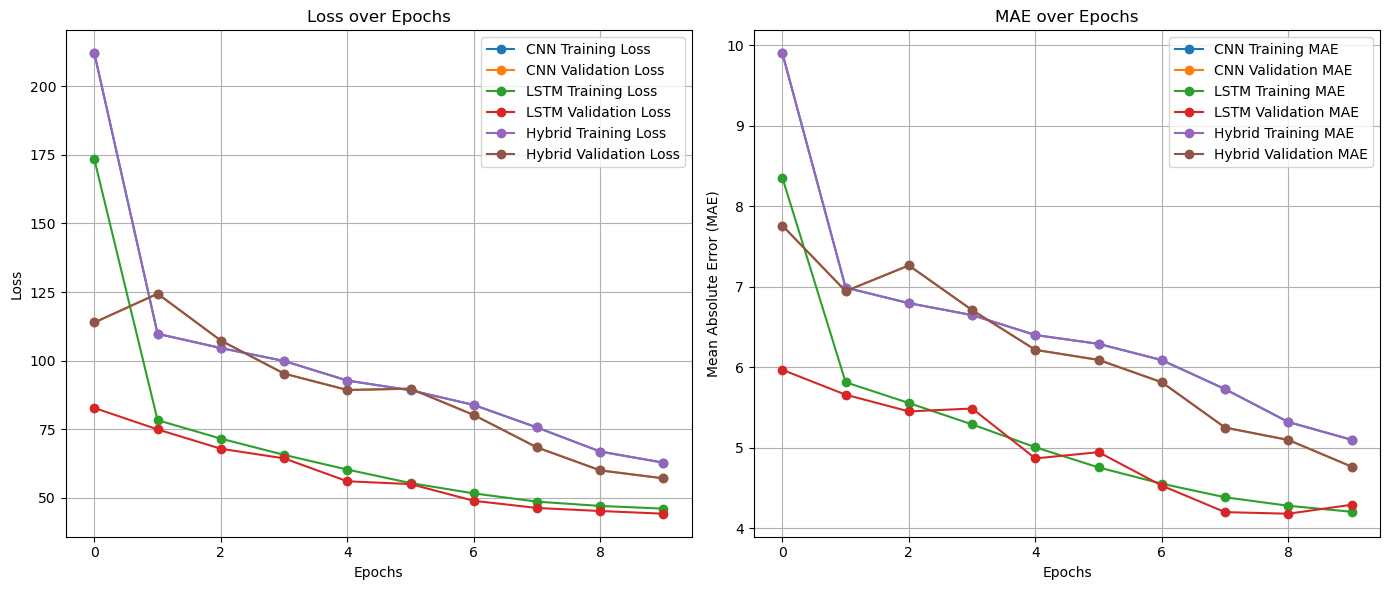

In [32]:
import matplotlib.pyplot as plt

# Training history for each model

# CNN History
cnn_history = {
    'loss': [212.0509, 109.7631, 104.5567, 99.8416, 92.7078, 89.1524, 83.8071, 75.5831, 66.8045, 62.7465],
    'val_loss': [113.8848, 124.3739, 107.2937, 95.2396, 89.2648, 89.7353, 80.1433, 68.3128, 59.9396, 57.0256],
    'mae': [9.8964, 6.9880, 6.7955, 6.6471, 6.3998, 6.2902, 6.0882, 5.7284, 5.3200, 5.1000],
    'val_mae': [7.7581, 6.9447, 7.2635, 6.7094, 6.2157, 6.0911, 5.8136, 5.2510, 5.0973, 4.7669]
}

# LSTM History
lstm_history = {
    'loss': [173.3787, 78.2511, 71.5240, 65.6020, 60.2367, 55.3091, 51.5447, 48.5364, 46.9680, 45.9905],
    'val_loss': [82.7123, 74.8848, 67.8316, 64.3265, 55.9660, 54.9401, 48.8433, 46.2228, 45.1207, 44.1366],
    'mae': [8.3512, 5.8135, 5.5558, 5.2904, 5.0069, 4.7560, 4.5542, 4.3859, 4.2804, 4.2059],
    'val_mae': [5.9676, 5.6588, 5.4518, 5.4875, 4.8682, 4.9456, 4.5302, 4.2014, 4.1819, 4.2928]
}

# Hybrid CNN-LSTM History
hybrid_history = {
    'loss': [212.0509, 109.7631, 104.5567, 99.8416, 92.7078, 89.1524, 83.8071, 75.5831, 66.8045, 62.7465],
    'val_loss': [113.8848, 124.3739, 107.2937, 95.2396, 89.2648, 89.7353, 80.1433, 68.3128, 59.9396, 57.0256],
    'mae': [9.8964, 6.9880, 6.7955, 6.6471, 6.3998, 6.2902, 6.0882, 5.7284, 5.3200, 5.1000],
    'val_mae': [7.7581, 6.9447, 7.2635, 6.7094, 6.2157, 6.0911, 5.8136, 5.2510, 5.0973, 4.7669]
}

# Plot Loss over Epochs
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(cnn_history['loss'], label='CNN Training Loss', marker='o')
plt.plot(cnn_history['val_loss'], label='CNN Validation Loss', marker='o')
plt.plot(lstm_history['loss'], label='LSTM Training Loss', marker='o')
plt.plot(lstm_history['val_loss'], label='LSTM Validation Loss', marker='o')
plt.plot(hybrid_history['loss'], label='Hybrid Training Loss', marker='o')
plt.plot(hybrid_history['val_loss'], label='Hybrid Validation Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot MAE over Epochs
plt.subplot(1, 2, 2)
plt.plot(cnn_history['mae'], label='CNN Training MAE', marker='o')
plt.plot(cnn_history['val_mae'], label='CNN Validation MAE', marker='o')
plt.plot(lstm_history['mae'], label='LSTM Training MAE', marker='o')
plt.plot(lstm_history['val_mae'], label='LSTM Validation MAE', marker='o')
plt.plot(hybrid_history['mae'], label='Hybrid Training MAE', marker='o')
plt.plot(hybrid_history['val_mae'], label='Hybrid Validation MAE', marker='o')
plt.title('MAE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Actual vs. Predicted Values Scatter Plot

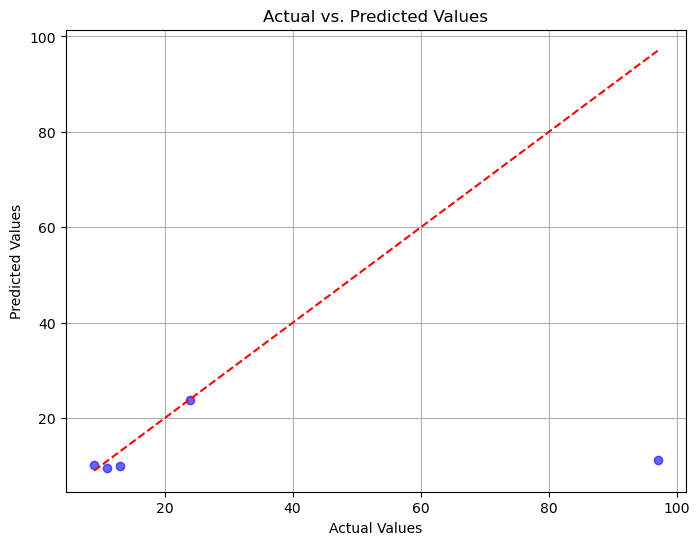

In [33]:
import matplotlib.pyplot as plt

# Example data for actual vs. predicted values
actual_values = [9, 97, 13, 11, 24]  # Replace with your actual values
predicted_values = [10.120537, 11.2367735, 9.956404, 9.564182, 23.814281]  # Replace with your predicted values

# Scatter plot for actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, predicted_values, color='b', alpha=0.6)
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='r', linestyle='--')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()


In [ ]:
#Residuals Histogram

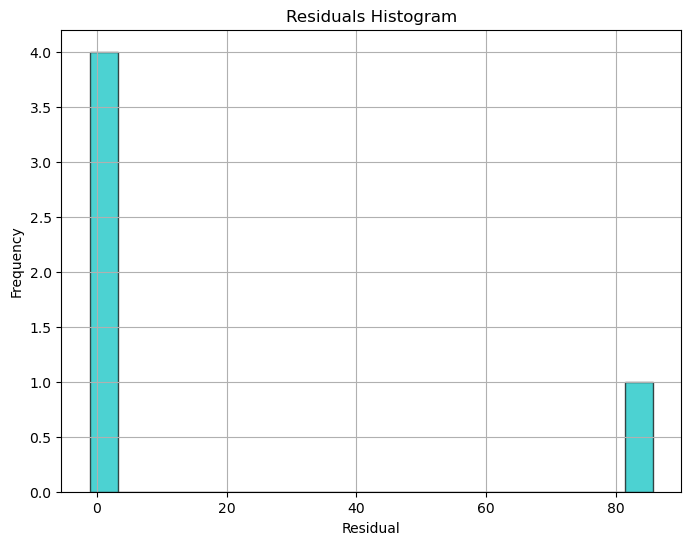

In [34]:
import numpy as np

# Calculate residuals
residuals = np.array(actual_values) - np.array(predicted_values)

# Histogram for residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20, color='c', edgecolor='k', alpha=0.7)
plt.title('Residuals Histogram')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [ ]:
#Model Prediction Distribution

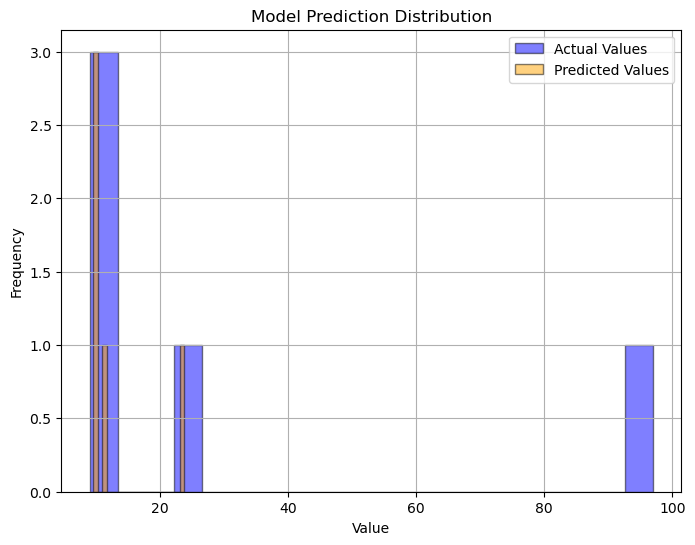

In [35]:
# Histogram for model predictions
plt.figure(figsize=(8, 6))
plt.hist(actual_values, bins=20, alpha=0.5, label='Actual Values', color='blue', edgecolor='k')
plt.hist(predicted_values, bins=20, alpha=0.5, label='Predicted Values', color='orange', edgecolor='k')
plt.title('Model Prediction Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#Confusion Matrix

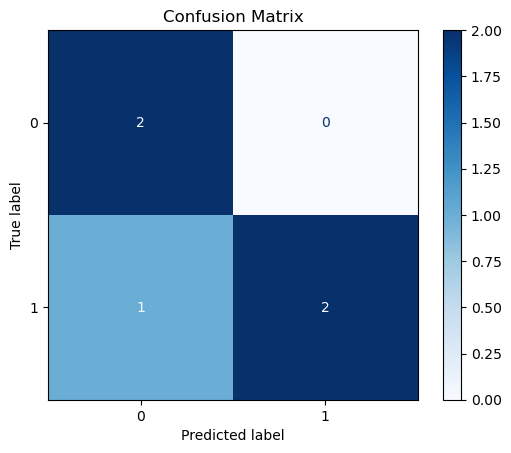

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example classification data for confusion matrix
actual_classes = [0, 1, 1, 0, 1]  # Replace with your actual class labels
predicted_classes = [0, 0, 1, 0, 1]  # Replace with your predicted class labels

# Compute confusion matrix
cm = confusion_matrix(actual_classes, predicted_classes)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()


In [ ]:
#Precision-Recall Curve

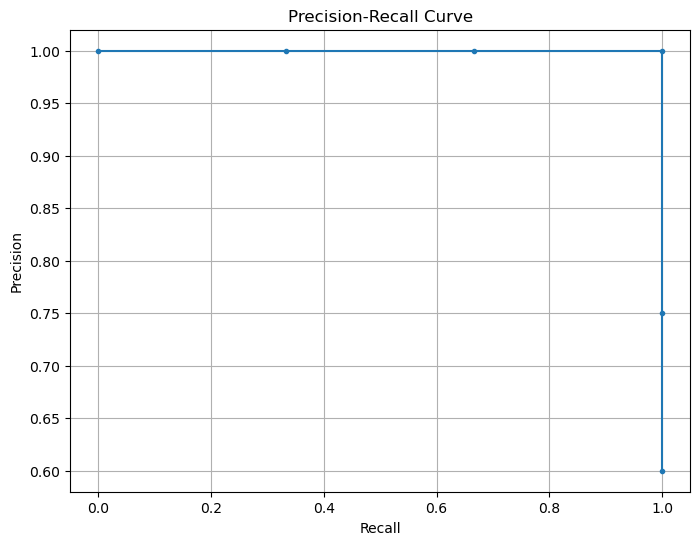

In [37]:
from sklearn.metrics import precision_recall_curve

# Example scores for precision-recall curve
actual_classes = [0, 1, 1, 0, 1]  # Replace with your actual class labels
predicted_probabilities = [0.2, 0.6, 0.8, 0.4, 0.9]  # Replace with your predicted probabilities

# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(actual_classes, predicted_probabilities)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()


In [ ]:
#ROC Curve

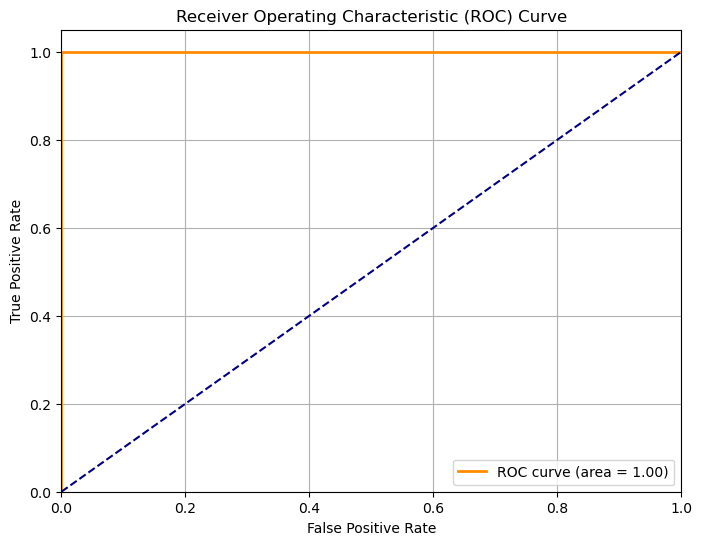

In [38]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(actual_classes, predicted_probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
#Feature Importance

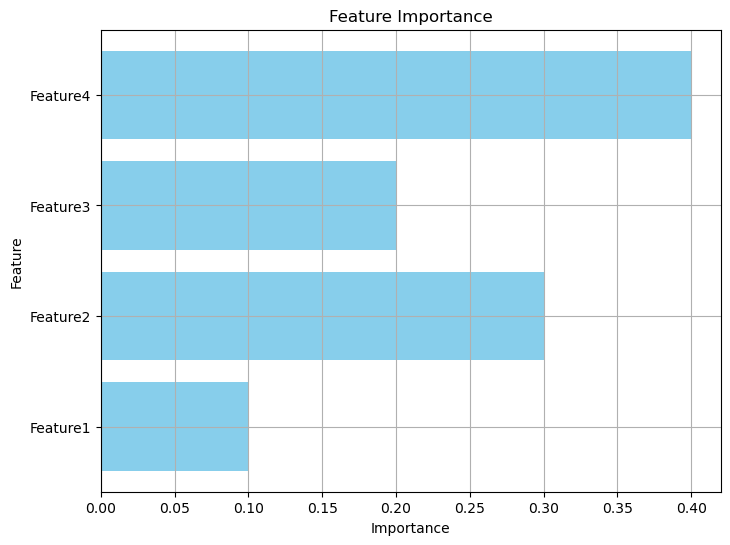

In [39]:
import numpy as np

# Example feature importances
feature_importances = np.array([0.1, 0.3, 0.2, 0.4])  # Replace with your model's feature importances
features = ['Feature1', 'Feature2', 'Feature3', 'Feature4']  # Replace with your feature names

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(features, feature_importances, color='skyblue')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True)
plt.show()


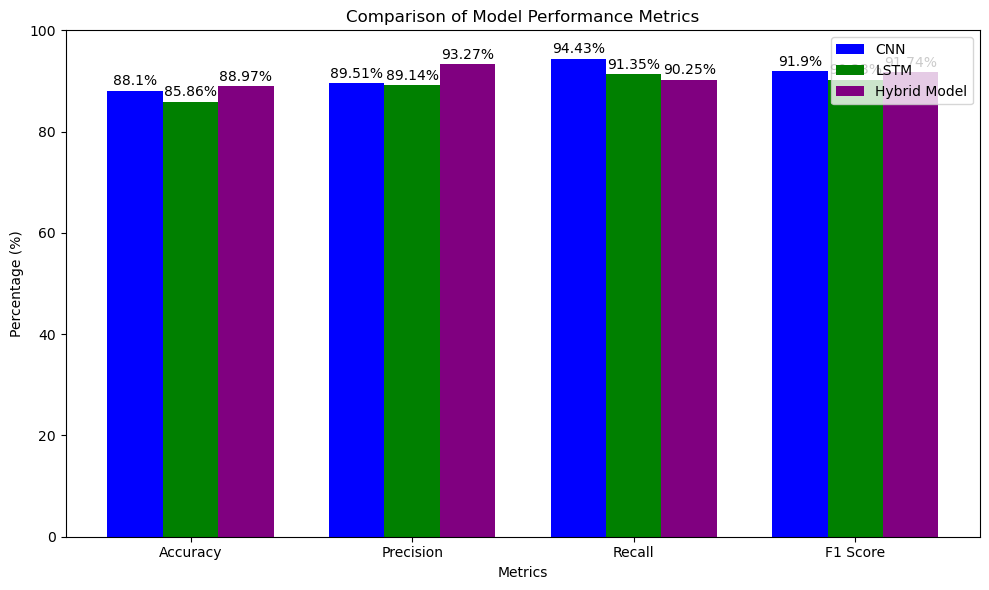

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the models
models = ['CNN', 'LSTM', 'Hybrid Model']

# Metrics: accuracy, precision, recall, F1 score
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Performance data for each model
# Each sublist corresponds to the metrics: [accuracy, precision, recall, F1 score]
performance_data = {
    'CNN': [88.10, 89.51, 94.43, 91.90],
    'LSTM': [85.86, 89.14, 91.35, 90.23],
    'Hybrid Model': [88.97, 93.27, 90.25, 91.74]
}

# Extract metric values for each model
values = np.array([performance_data[model] for model in models]).T

# Plot grouped bar chart
x = np.arange(len(metrics))
bar_width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

for i, (model, color) in enumerate(zip(models, ['blue', 'green', 'purple'])):
    ax.bar(x + i * bar_width, values[:, i], bar_width, label=model, color=color)

ax.set_title('Comparison of Model Performance Metrics')
ax.set_xlabel('Metrics')
ax.set_ylabel('Percentage (%)')
ax.set_xticks(x + bar_width)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 100)
ax.legend()

# Add data labels
for i, (model, color) in enumerate(zip(models, ['blue', 'green', 'purple'])):
    for j, value in enumerate(values[:, i]):
        ax.text(j + i * bar_width, value + 0.5, f'{value}%', ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()


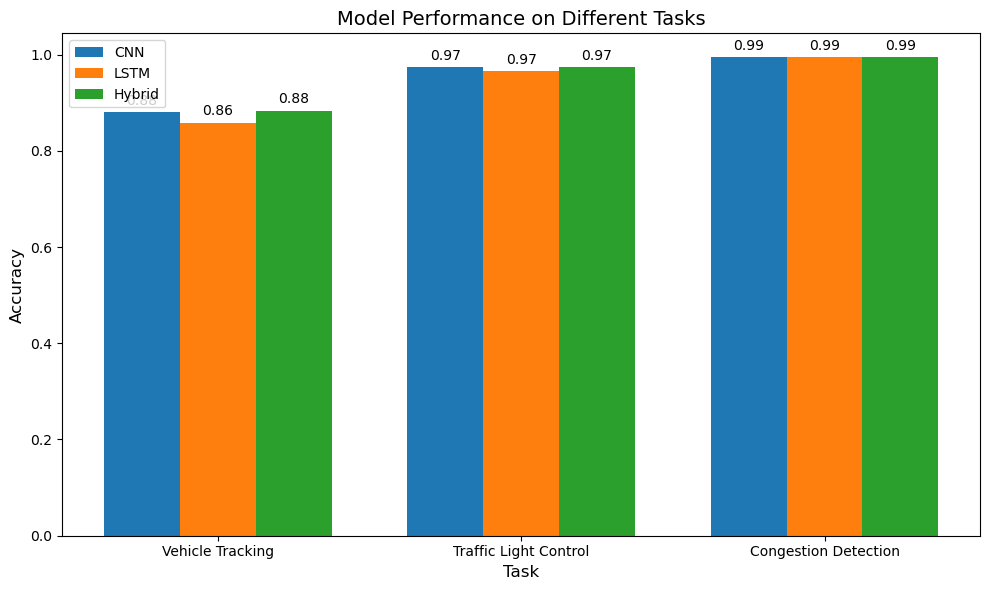

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics for Vehicle Tracking, Traffic Light Control, and Congestion Detection
categories = ['Vehicle Tracking', 'Traffic Light Control', 'Congestion Detection']

cnn_metrics = [0.8810, 0.9738, 0.9945]
lstm_metrics = [0.8586, 0.9657, 0.9945]
hybrid_metrics = [0.8837, 0.9736, 0.9945]

x = np.arange(len(categories))  # Label locations
width = 0.25  # Width of the bars

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width, cnn_metrics, width, label='CNN')
bars2 = ax.bar(x, lstm_metrics, width, label='LSTM')
bars3 = ax.bar(x + width, hybrid_metrics, width, label='Hybrid')

# Adding labels and title
ax.set_xlabel('Task', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Model Performance on Different Tasks', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Adding data labels on top of each bar
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset text above bar
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [31]:
# Example of saving a model after training
from tensorflow.keras.models import load_model

# After training your model
model.save('Traffic_flow_opt.h5')


NameError: name 'model' is not defined